In [9]:
import keras
from keras.models import Sequential, Model

from keras.utils import np_utils
from keras.optimizers import SGD 
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, UpSampling2D, Input, BatchNormalization, RepeatVector

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [2]:
X , v = generate_a_triangle()

In [3]:
X

array([255., 255., 255., ..., 255., 255., 255.])

## 2 Getting started

Let's have a quick look at the data that we are supposed to classify. We can see that there are three kinds of shapes. We can add noise and choose to center them or not

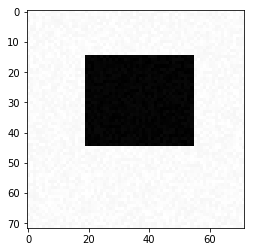

In [4]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

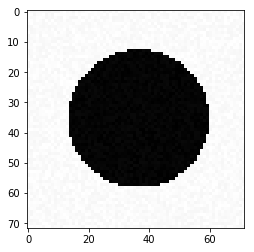

In [5]:
im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

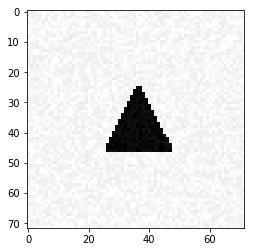

In [6]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')

## 3 Simple classification

For this first step we'll consider a simple model to classify shapes that are centered. Since the model won't be too deep, we'ill be able to work with a thousand samples that we'll split in two parts (20% and 80%) for testing and training.

Since we have three classes, we'll try a first neural network  with a layer of three neurons.

In [8]:
[X_train, Y_train] = generate_dataset_classification(1000, 20,False)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


Here is the first try to categorize the data thanks to the SGD optimizer with which we get 94% accuracy. With other parameters such as lr=0.01, we get 100% accuracy, which could mean overfitting.

In [20]:
y_train = np_utils.to_categorical(Y_train, num_classes=3)
sgd = SGD(lr=0.0008,decay=0.1, momentum=0.9,  nesterov=False) 
classifier = Sequential()

classifier.add(Dense(units = 3, activation='softmax'))

classifier.compile(optimizer = sgd, 
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, 
               y_train,
               batch_size = 32,
               epochs =12,
               validation_split=0.2);

Train on 800 samples, validate on 200 samples
Epoch 1/12
800/800 [==============================] - 0s 439us/step - loss: 0.9542 - acc: 0.5600 - val_loss: 0.7172 - val_acc: 0.7150
Epoch 2/12
800/800 [==============================] - 0s 163us/step - loss: 0.6105 - acc: 0.7275 - val_loss: 0.5542 - val_acc: 0.7200
Epoch 3/12
800/800 [==============================] - 0s 150us/step - loss: 0.5045 - acc: 0.8313 - val_loss: 0.4907 - val_acc: 0.8650
Epoch 4/12
800/800 [==============================] - 0s 188us/step - loss: 0.4709 - acc: 0.8475 - val_loss: 0.4815 - val_acc: 0.8100
Epoch 5/12
800/800 [==============================] - 0s 175us/step - loss: 0.4628 - acc: 0.8275 - val_loss: 0.4601 - val_acc: 0.8750
Epoch 6/12
800/800 [==============================] - 0s 162us/step - loss: 0.4388 - acc: 0.8675 - val_loss: 0.4295 - val_acc: 0.9250
Epoch 7/12
800/800 [==============================] - 0s 163us/step - loss: 0.4256 - acc: 0.8837 - val_loss: 0.4286 - val_acc: 0.9300
Epoch 8/12
800/8

Here is an attempt with the adam optimizer. With this optimizer, we have a better accuracy as well as a quicker convergence

In [26]:
y_train = np_utils.to_categorical(Y_train, num_classes=3)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.95, epsilon=None, decay=0.0, amsgrad=False) 
classifier = Sequential()

classifier.add(Dense(units = 3, activation='softmax'))
classifier.compile(optimizer = adam, 
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, 
               y_train,
               batch_size = 32,
               epochs =10,
               validation_split=0.2);

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 587us/step - loss: 0.8549 - acc: 0.6550 - val_loss: 0.3955 - val_acc: 0.8400
Epoch 2/10
800/800 [==============================] - 0s 164us/step - loss: 0.4262 - acc: 0.7950 - val_loss: 0.3176 - val_acc: 0.8200
Epoch 3/10
800/800 [==============================] - 0s 164us/step - loss: 0.2351 - acc: 0.9163 - val_loss: 0.2526 - val_acc: 0.8750
Epoch 4/10
800/800 [==============================] - 0s 192us/step - loss: 0.1801 - acc: 0.9363 - val_loss: 0.1531 - val_acc: 0.9100
Epoch 5/10
800/800 [==============================] - 0s 184us/step - loss: 0.1138 - acc: 0.9888 - val_loss: 0.1135 - val_acc: 1.0000
Epoch 6/10
800/800 [==============================] - 0s 173us/step - loss: 0.0856 - acc: 0.9950 - val_loss: 0.0660 - val_acc: 1.0000
Epoch 7/10
800/800 [==============================] - 0s 164us/step - loss: 0.0680 - acc: 0.9975 - val_loss: 0.1547 - val_acc: 0.9800
Epoch 8/10
800/8

In [28]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
classifier.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

This corresponds to the category 1 : the circle. This prediction is accurate!

## 4 Visualization of the solution 

We'll try to visualuze the weights of the Network for each category as a picture to try to understand how the Network reacts to the data

Category 0 : rectangle


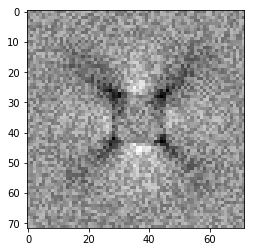

In [43]:
print("Category 0 : rectangle")
plt.imshow(classifier.get_weights()[0][:,0].reshape(72,72), cmap="gray");

Category 1 : circle 


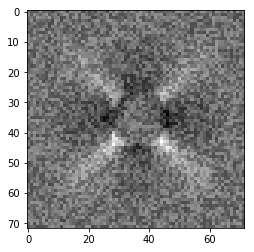

In [44]:
print("Category 1 : circle ")
plt.imshow(classifier.get_weights()[0][:,1].reshape(72,72), cmap="gray");

Category 0 : triangle


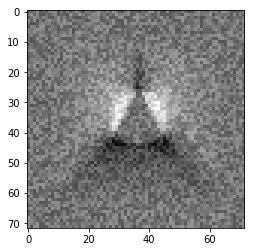

In [45]:
print("Category 0 : triangle")
plt.imshow(classifier.get_weights()[0][:,2].reshape(72,72), cmap="gray");

We can see that the model tends to focus on the the edges and borders. There might be an issue with the model to  classify rectangles and cirles. Indeed, the "picture" of the circle looks like a 45° rotated rectangle.

## 5 A More difficult classification problem

To add difficulty to the classification, we add True in the Training set creation function in order to generate shapes that are not centered 

In [67]:
[X_train, Y_train] = generate_dataset_classification(2000, 20, True)
y_train = np_utils.to_categorical(Y_train, num_classes=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990


In [47]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [66]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.90, epsilon=None, decay=0.0, amsgrad=False) 
classifier = Sequential()

classifier.add(Dense(units = 3, activation='softmax'))
classifier.compile(optimizer = adam, 
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, 
               y_train,
               batch_size = 32,
               epochs =50);
print("loss of the model :",classifier.evaluate(X_test,Y_test)[0])
print(" accuracy: ",classifier.evaluate(X_test,Y_test)[1])


Epoch 1/50
1000/1000 [==============================] - 1s 730us/step - loss: 1.3517 - acc: 0.3650
Epoch 2/50
1000/1000 [==============================] - 0s 160us/step - loss: 1.1746 - acc: 0.4490
Epoch 3/50
1000/1000 [==============================] - 0s 159us/step - loss: 0.9929 - acc: 0.4930
Epoch 4/50
1000/1000 [==============================] - 0s 151us/step - loss: 0.9308 - acc: 0.5370
Epoch 5/50
1000/1000 [==============================] - 0s 160us/step - loss: 0.9750 - acc: 0.5800
Epoch 6/50
1000/1000 [==============================] - 0s 150us/step - loss: 0.8992 - acc: 0.5700
Epoch 7/50
1000/1000 [==============================] - 0s 150us/step - loss: 0.9213 - acc: 0.5610
Epoch 8/50
1000/1000 [==============================] - 0s 160us/step - loss: 0.8853 - acc: 0.5540
Epoch 9/50
1000/1000 [==============================] - 0s 160us/step - loss: 0.8704 - acc: 0.5450
Epoch 10/50
1000/1000 [==============================] - 0s 150us/step - loss: 0.8635 - acc: 0.5780
Epoch 11/

The accuracy is way worse than before. The model overfits a little because the accuracy on the test set is worse than on the training set. 
We are now trying to implement a convolutionnal network to have better results

In [68]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.90, epsilon=None, decay=0.0, amsgrad=False) 
classifier = Sequential()

classifier.add(Conv2D(16, (5,5), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Flatten())
classifier.add(Dense(64,activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(3,activation='softmax'))


classifier.compile(optimizer = adam, 
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(np.reshape(X_train, (X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)), 
               y_train,
               batch_size = 100,
               epochs =40);
print("loss of the model :",classifier.evaluate(np.reshape(X_test, (X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),Y_test)[0])
print(" accuracy: ",classifier.evaluate(np.reshape(X_test, (X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),Y_test)[1])


Epoch 1/40
2000/2000 [==============================] - 2s 853us/step - loss: 1.1148 - acc: 0.4095
Epoch 2/40
2000/2000 [==============================] - 1s 350us/step - loss: 0.9511 - acc: 0.5535
Epoch 3/40
2000/2000 [==============================] - 1s 355us/step - loss: 0.8142 - acc: 0.6335
Epoch 4/40
2000/2000 [==============================] - 1s 370us/step - loss: 0.7574 - acc: 0.6615
Epoch 5/40
2000/2000 [==============================] - 1s 355us/step - loss: 0.6939 - acc: 0.7135
Epoch 6/40
2000/2000 [==============================] - 1s 357us/step - loss: 0.6484 - acc: 0.7400
Epoch 7/40
2000/2000 [==============================] - 1s 363us/step - loss: 0.6214 - acc: 0.7615
Epoch 8/40
2000/2000 [==============================] - 1s 359us/step - loss: 0.5747 - acc: 0.7875
Epoch 9/40
2000/2000 [==============================] - 1s 353us/step - loss: 0.5084 - acc: 0.8110
Epoch 10/40
2000/2000 [==============================] - 1s 360us/step - loss: 0.5010 - acc: 0.8195
Epoch 11/

With this convolutionnal network and a larger training set, we obtain a precision of 92%. 
By adding layers, we could potentially reach a better accuracy

## 6 A Regression Problem

We'll try to find the vertices of triangles thanks to the new training set thanks to a convolutionnal network

In [39]:
[X_train, Y_train] = generate_dataset_regression(20000, 20)

Creating data:


In [40]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:


In [22]:
def transform(Y) :
    Y_trans =np.zeros((Y.shape[0],6,6))
    for i in range(Y.shape[0]):
        int_Y = Y[i,:]
        vect=[]
        for k in range(3):
            for j in range(3):
                for l in range(3):
                    if j != l and k != j and k !=l:
                        vect.append(
                            [int_Y[2 * k], int_Y[2 * k + 1], int_Y[2 * j], int_Y[2 * j + 1], int_Y[2 * l], int_Y[2 * l + 1]])
        Y_trans[i,:] = np.array(vect)
    return Y_trans

In [41]:
Y_trans = transform(Y_train)
Y_test_trans = transform(Y_test)

The issue with the triangle generation is that the vertices are not sorted. We want the loss to be the same, no matter how the list of vertices is ordered. In order to do such a thing, we can create a loss function that is similar whatever permutation we apply to the list of vertices. This is basically the minimum distance on all combinations of the coordonates

In [6]:
import keras.backend.tensorflow_backend as K
def loss_perm(y_true, y_pred):
    return K.min(K.sum(K.square(y_pred - y_true), axis=-1), axis=1)

In [46]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False) 
classifier = Sequential()

classifier.add(Conv2D(16, (3,3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(32, (3,3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(64, (3,3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Flatten())
classifier.add(Dense(64,activation='relu'))
classifier.add(Dropout(0.075))
classifier.add(Dense(6))
classifier.add(RepeatVector(6))

#train_gen = DataGenerator()
#valid_gen = DataGenerator(batch_per_epoch=1)

classifier.compile(optimizer = adam, 
                   loss = loss_perm)

# Fitting the ANN to the Training set
classifier.fit(np.reshape(X_train, (X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)), 
               Y_trans,
               batch_size = 256,
               epochs = 175);

print("loss of the model : ",classifier.evaluate(np.reshape(X_test, (X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),Y_test_trans))

Epoch 1/175
20000/20000 [==============================] - 14s 683us/step - loss: 0.2949
Epoch 2/175
20000/20000 [==============================] - 11s 526us/step - loss: 0.1314
Epoch 3/175
20000/20000 [==============================] - 10s 505us/step - loss: 0.1057
Epoch 4/175
20000/20000 [==============================] - 11s 531us/step - loss: 0.0930
Epoch 5/175
20000/20000 [==============================] - 10s 522us/step - loss: 0.0871
Epoch 6/175
20000/20000 [==============================] - 10s 499us/step - loss: 0.0815
Epoch 7/175
20000/20000 [==============================] - 10s 493us/step - loss: 0.0782
Epoch 8/175
20000/20000 [==============================] - 10s 488us/step - loss: 0.0756
Epoch 9/175
20000/20000 [==============================] - 10s 487us/step - loss: 0.0734
Epoch 10/175
20000/20000 [==============================] - 10s 487us/step - loss: 0.0720
Epoch 11/175
20000/20000 [==============================] - 12s 595us/step - loss: 0.0710
Epoch 12/175
20000/

20000/20000 [==============================] - 9s 463us/step - loss: 0.0489
Epoch 93/175
20000/20000 [==============================] - 9s 473us/step - loss: 0.0488
Epoch 94/175
20000/20000 [==============================] - 9s 467us/step - loss: 0.0480
Epoch 95/175
20000/20000 [==============================] - 9s 465us/step - loss: 0.0488
Epoch 96/175
20000/20000 [==============================] - 9s 466us/step - loss: 0.0487
Epoch 97/175
20000/20000 [==============================] - 9s 455us/step - loss: 0.0484
Epoch 98/175
20000/20000 [==============================] - 9s 470us/step - loss: 0.0486
Epoch 99/175
20000/20000 [==============================] - 9s 446us/step - loss: 0.0481
Epoch 100/175
20000/20000 [==============================] - 9s 436us/step - loss: 0.0482
Epoch 101/175
20000/20000 [==============================] - 9s 438us/step - loss: 0.0478
Epoch 102/175
20000/20000 [==============================] - 9s 428us/step - loss: 0.0481
Epoch 103/175
20000/20000 [====

By adding all the possible combinations, the model is way heavier but reaches better results.

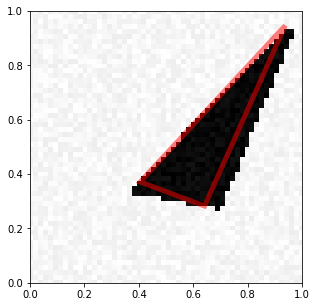

In [47]:
visualize_prediction(X_test[0], classifier.predict(np.reshape(X_test[0],(1,IMAGE_SIZE, IMAGE_SIZE, 1)))[0,:][0])

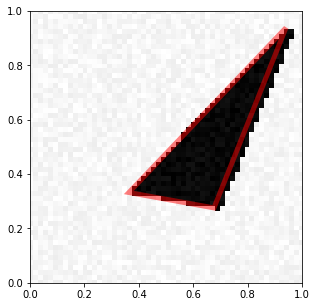

In [48]:
visualize_prediction(X_test[0], Y_test[0])

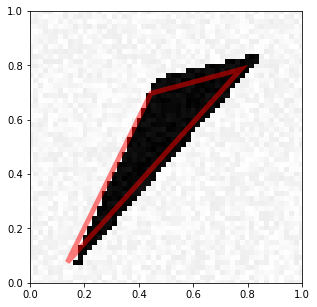

In [51]:
visualize_prediction(X_test[100], classifier.predict(np.reshape(X_test[100],(1,IMAGE_SIZE, IMAGE_SIZE, 1)))[0,:][0])

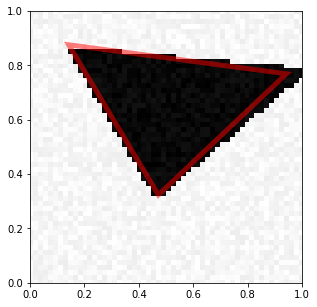

In [52]:
visualize_prediction(X_test[200], classifier.predict(np.reshape(X_test[200],(1,IMAGE_SIZE, IMAGE_SIZE, 1)))[0,:][0])

The results are way better than without the normalization

## 7 Image Denoising



In [8]:
def generate_dataset_classification_noise(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
            Y[i] = generate_a_rectangle(0, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
            Y[i] = generate_a_disk(0, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
            [Y[i], V] = generate_a_triangle(0, free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = Y / 255
    return [X, Y]

In [9]:
X_train, Y_train = generate_dataset_classification_noise(4000, noise=50)

Creating data:


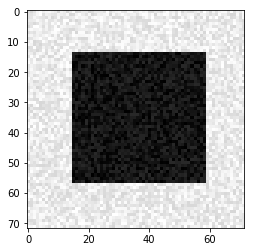

In [125]:
plt.imshow(np.reshape(X_train[100, :], (IMAGE_SIZE, IMAGE_SIZE)), cmap="gray");

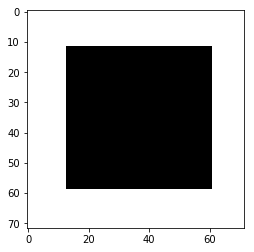

In [126]:
plt.imshow(np.reshape(Y_train[100, :], (IMAGE_SIZE, IMAGE_SIZE)), cmap="gray");

In [12]:
input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), padding='same', activation="sigmoid")(x)

model = Model(input_img, decoded)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

model.compile(optimizer=adam, loss='mean_squared_error')
model.fit(
    np.reshape(X_train, (X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),
    np.reshape(Y_train, (X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),
    epochs=3,
    batch_size=64,
    validation_split=0.2
);

Train on 3200 samples, validate on 800 samples
Epoch 1/3
3200/3200 [==============================] - 4s 1ms/step - loss: 0.1301 - val_loss: 0.1094
Epoch 2/3
3200/3200 [==============================] - 4s 1ms/step - loss: 0.1043 - val_loss: 0.1039
Epoch 3/3
3200/3200 [==============================] - 4s 1ms/step - loss: 0.1022 - val_loss: 0.1034


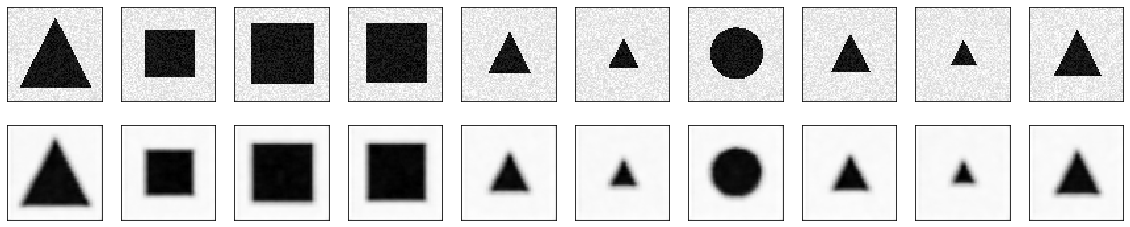

In [13]:
n = 10
decoded_imgs = model.predict(np.reshape(X_train[:n], (n, IMAGE_SIZE, IMAGE_SIZE, 1)))

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(decoded_imgs[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The model manages to reduce drastically the noise outside the shapes. However the borders tend to become blurry.